# Bulk RNA-seq to Single RNA-seq

Bulk2Single is used for bulk RNA-seq deconvolution algorithm. We extracted the beta-VAE part of the Bulk2Space algorithm and constructed an algorithm that can deconvolute from Bulk RNA-seq to Single Cell RNA-seq. In addition, we have redesigned the input and output of the data so that it can be more compatible with the analysis conventions in the Python environment.

This tutorial walks through how to read, set-up and train the model from bulk RNA-seq and reference scRNA-seq data. We use the pdac datasets as example

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import Pyomic
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

## loading data

Bulk2Single deconvoluted the scRNA-seq from bulk RNA-seq, we need an average expression matrix of Bulk RNA-seq, index is the gene name and Columns only needs one, in this case we need to calculate the average of the samples.

We also need an anndata object of scRNA-seq as reference to deconvolute the Bulk matrix. The data can be downloaded from [here](https://drive.google.com/file/d/1xB-Gk_KLxQA320-tycJp4CFHA66zF3LE/view?usp=sharing). The processed PDAC bulk-seq data (GSE171485) by Wu et.al., the PDAC scRNA-seq data and ST data (GSE111672)

In [3]:
bulk_data=pd.read_csv('data/pdac/pdac_bulk.csv',index_col=0)
bulk_data.head()

,PDAC.4
TSPAN6,2.539709
TNMD,1.012851
DPM1,1.663841
SCYL3,1.352015
C1orf112,0.162467


In [4]:
import anndata
raw_data=pd.read_csv('data/pdac/sc_data.csv', index_col=0)
single_data=anndata.AnnData(raw_data.T)
single_data.obs = pd.read_csv('data/pdac/sc_meta.csv', index_col=0)[['Cell_type']]
single_data

AnnData object with n_obs × n_vars = 1926 × 19104
    obs: 'Cell_type'

## set up, training, saving, and loading

We can now set up the Bulk2Single object, which will ensure everything the model needs is in place for training. We need to specify the cell type of the scRNA-seq to deconvolute the Bulk RNA-seq. And specify the number of marker genes for each cell type for training.

In [5]:
model=Pyomic.bulk2single.Bulk2Single(bulk_data=bulk_data,single_data=single_data,celltype_key='Cell_type',
                 top_marker_num=200,ratio_num=1,gpu=0)

...loading data
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


Now we can start to train our Bulk2Single model.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    the default max epochs is set to 3500, but in practice Bulk2Single stops early once the model converges, which rarely requires that many, especially for large datasets.(We can set the `patience` to control the stop steps)
  </p>
</div>

In [ ]:
vae_net=model.train(
    batch_size=512,
    learning_rate=1e-4,
    hidden_size=256,
    epoch_num=3500,
    vae_save_dir='data/pdac/newdata/save_model',
    vae_save_name='pdac_vae',
    generate_save_dir='data/pdac/newdata/output',
    generate_save_name='pdac')

We can plot the vae loss use a simple method named `plot_loss`

In [ ]:
model.plot_loss()

We can also load our previously trained model directly

In [6]:
vae_net=model.load('data/pdac/newdata/save_model/pdac_vae.pth')

loading model from data/pdac/newdata/save_model/pdac_vae.pth


Now, we can generate an Bulk2Single deconvoluted scRNA-seq matrix from our model.

In [9]:
generate_adata=model.generate()
generate_adata

...generating


generating: 100%|███████████████████████| 1926/1926.0 [00:01<00:00, 1860.00it/s]

generated done!


AnnData object with n_obs × n_vars = 1926 × 15108
    obs: 'Cell_type'

## visualizing and analyzing the correlation

We need to test the characteristics of the generated single cell RNA-seq and the correlation with the reference scRNA-seq. Here, we calculated the correlation between the cell type of the reference scRNA-seq and the cell type of the generated scRNA-seq using the Pearson coefficient using the cell type-specific marker of the reference scRNA-seq as an anchor point.

<AxesSubplot: title={'center': 'The number of cells per cell type in bulk-seq data'}, xlabel='Cell type', ylabel='Cell number'>

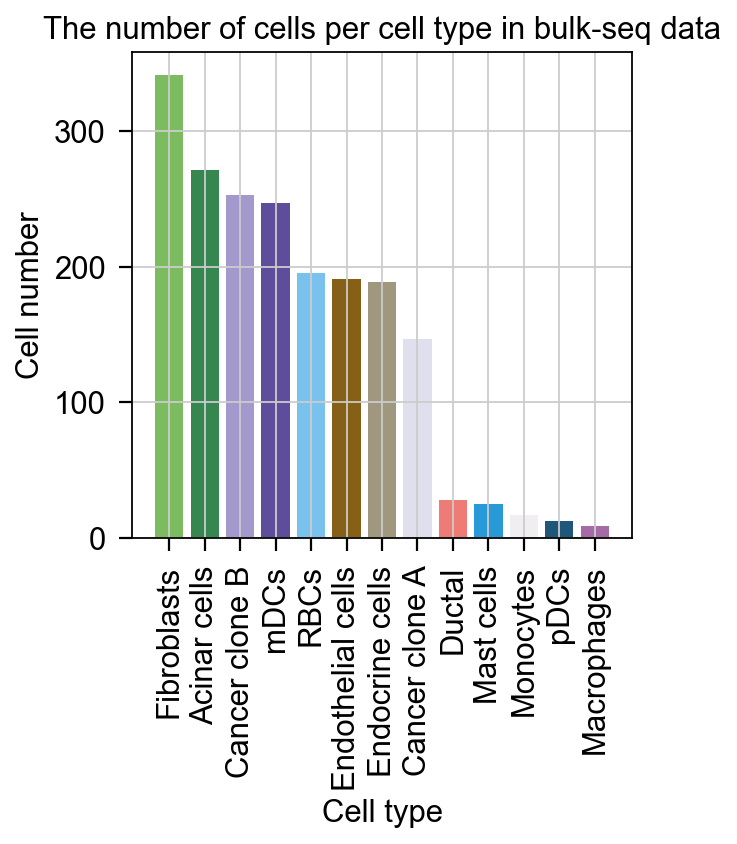

In [12]:
Pyomic.bulk2single.bulk2single_plot_cellprop(generate_adata,celltype_key='Cell_type')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


<AxesSubplot: title={'center': 'Expression correlation'}, xlabel='scRNA-seq reference', ylabel='deconvoluted bulk-seq'>

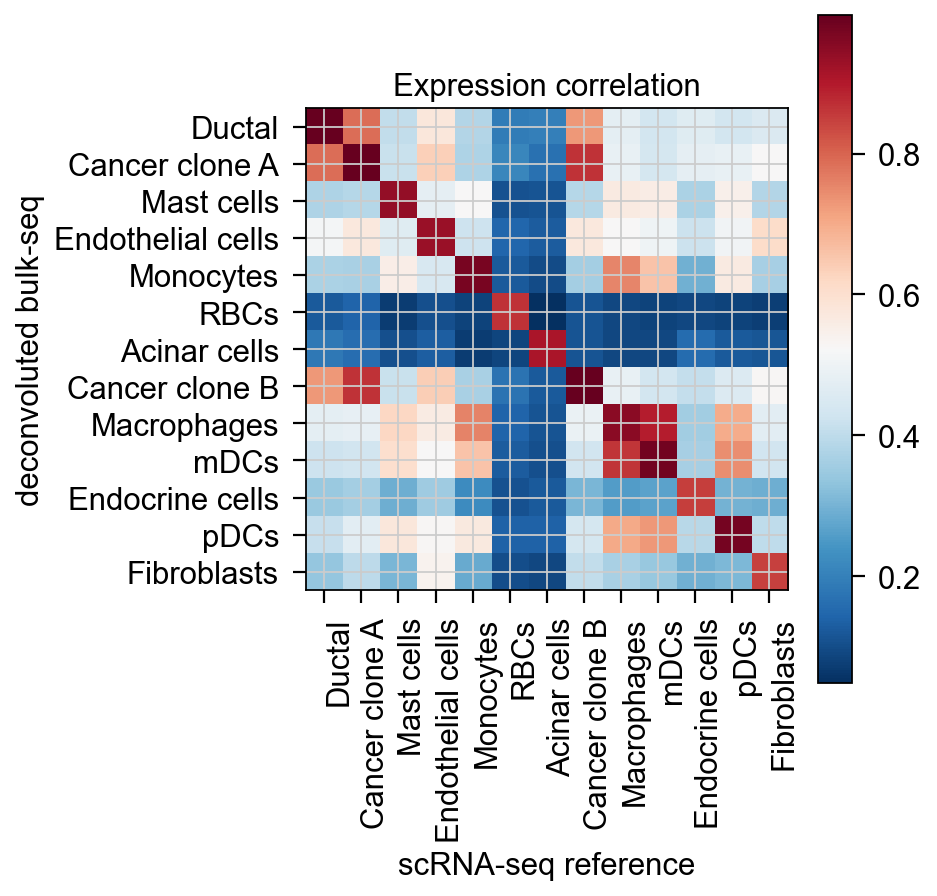

In [11]:
Pyomic.bulk2single.bulk2single_plot_correlation(single_data,generate_adata,celltype_key='Cell_type')